# **III. Entrainement des Models**

## **1. Importation des bibliothèques et du jeu de données (préparé préalablement)**


Nous commençons par l'importation des bibliothèques nécessaires telles que pandas, numpy et pyspark. Ces bibliothèques sont essentielles pour le traitement des données, la manipulation des tableaux et la mise en œuvre des algorithmes d'apprentissage automatique à grande échelle. 

In [4]:
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator,MulticlassClassificationEvaluator
from pyspark.ml.classification import LinearSVC
from sklearn.metrics import classification_report
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from prettytable import PrettyTable

En utilisant SparkSession de pyspark.sql, nous initialisons une session Spark, ce qui nous permettra de manipuler des données distribuées de manière efficace.

In [5]:
# Initialisation de la session Spark // Port : 4040
# Une fois la seesion crée, on peut interagir avec les données stockées dans un environnement distribué.
spark = SparkSession.builder.appName('HeartDiseasesPredicion').config("spark.ui.port", "4041").config("spark.driver.maxResultSize", "4g").getOrCreate()

Nous procédons ensuite à l'importation des données à partir du fichier CSV 'clean_data.csv' contenant les données traitées précédemment à l'aide de la méthode spark.read.csv() de Spark

In [6]:
# Importing data
path = 'clean_data.csv'
data = spark.read.csv(path, header=True, inferSchema=True)

Ensuite, nous assemblons les caractéristiques pertinentes en un vecteur à l'aide de VectorAssembler de pyspark.ml.feature. Nous définissons une liste de colonnes 'feature_columns' qui contient les noms des caractéristiques que nous voulons inclure dans notre vecteur de caractéristiques.

In [7]:
# Assembler les caractéristiques en un vecteur
feature_columns = ['age', 'education', 'sex', 'is_smoking', 'cigs_per_day', 'bp_meds', 'prevalent_stroke', 'prevalent_hyp', 'diabetes', 'total_cholesterol', 'bmi', 'heart_rate', 'glucose', 'pulse_pressure']
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data = assembler.transform(data)

Ensuite, nous divisons nos données en ensembles d'entrainement et de test à l'aide de la méthode randomSplit de Spark.

In [8]:
# Diviser les données en ensembles de formation et de test
(trainingData, testData) = data.randomSplit([0.7, 0.3], seed=42)


Ensuite, nous configurons un évaluateur pour évaluer les performances de nos modèles sur les données de test. Dans ce cas, nous utilisons BinaryClassificationEvaluator de pyspark.ml.evaluation, spécifiant la colonne contenant les étiquettes de nos données (labelCol="ten_year_chd").

In [9]:
# Évaluer les modèles sur les données de test
evaluator = BinaryClassificationEvaluator(labelCol="ten_year_chd")


Ensuite, nous créons un évaluateur spécifiquement pour mesurer le rappel (recall) des modèles sur les données de test. Pour cela, nous utilisons MulticlassClassificationEvaluator de pyspark.ml.evaluation, en spécifiant la colonne contenant les étiquettes réelles (labelCol="ten_year_chd"), la colonne contenant les prédictions des modèles, et le nom de la métrique que nous voulons calculer (metricName="weightedRecall").

In [19]:
# Créer un évaluateur pour le recall
evaluator_recall = MulticlassClassificationEvaluator(labelCol="ten_year_chd", predictionCol="prediction", metricName="weightedRecall")


## **2. Logistic Regression**

Dans cette section, nous abordons la première technique de modélisation, à savoir la régression logistique. Nous utilisons la bibliothèque pyspark.ml.classification pour mettre en œuvre ce modèle. Nous instancions un objet LogisticRegression en spécifiant les colonnes contenant les étiquettes (labelCol="ten_year_chd") et les caractéristiques (featuresCol="features") dans nos données.

In [10]:
# Entraîner plusieurs modèles de classification
log_reg = LogisticRegression(labelCol="ten_year_chd", featuresCol="features")

Nous définissons ici une grille de paramètres à tester pour le modèle de régression logistique. Nous utilisons ParamGridBuilder de pyspark.ml.tuning pour spécifier les différentes combinaisons de paramètres que nous voulons évaluer lors de l'entraînement du modèle.

In [11]:
# Paramètres à tester pour chaque modèle
param_grid_log_reg = ParamGridBuilder() \
    .addGrid(log_reg.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(log_reg.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()


Nous créons ici un validateur croisé (CrossValidator) pour le modèle de régression logistique.
Le validateur croisé exécutera la validation croisée sur différentes combinaisons de paramètres, sélectionnant finalement la combinaison optimale qui maximise les performances du modèle selon les critères définis par l'évaluateur.

In [12]:
# Instancier les validateurs pour chaque modèle
cv_log_reg = CrossValidator(estimator=log_reg,
                            estimatorParamMaps=param_grid_log_reg,
                            evaluator=evaluator,
                            numFolds=5)

Nous procédons ici à l'entraînement du validateur croisé pour le modèle de régression logistique. 

In [13]:
# Entraîner les validateurs
cv_log_reg_model = cv_log_reg.fit(trainingData)

Nous sélectionnons ici le meilleur modèle de régression logistique parmi ceux entraînés par le validateur croisé.

In [14]:
# Sélectionner les meilleurs modèles
best_log_reg_model = cv_log_reg_model.bestModel

Nous évaluons ici les performances du meilleur modèle de régression logistique sur l'ensemble de test. En utilisant l'évaluateur que nous avons précédemment défini

In [15]:
# Évaluer les meilleurs modèles
log_reg_test_results = evaluator.evaluate(best_log_reg_model.transform(testData))
print("Logistic Regression Test Area Under ROC:", log_reg_test_results)

Logistic Regression Test Area Under ROC: 0.733519537361439


 *le résultat obtenu pour l'AUC de la régression logistique sur l'ensemble de test est d'environ 0.734, ce qui indique que le modèle a une capacité modérée à bien discriminer entre les individus à risque de développer une maladie cardiaque et ceux qui ne le sont pas.*

In [16]:
# Afficher les meilleurs paramètres pour Logistic Regression
best_log_reg_params = cv_log_reg_model.bestModel.extractParamMap()
print("Meilleurs paramètres pour Logistic Regression:")
for param in best_log_reg_params:
    print(param.name, ":", best_log_reg_params[param])

Meilleurs paramètres pour Logistic Regression:
aggregationDepth : 2
elasticNetParam : 0.0
family : auto
featuresCol : features
fitIntercept : True
labelCol : ten_year_chd
maxBlockSizeInMB : 0.0
maxIter : 100
predictionCol : prediction
probabilityCol : probability
rawPredictionCol : rawPrediction
regParam : 0.01
standardization : True
threshold : 0.5
tol : 1e-06


Nous générons ici un rapport de classification pour évaluer plus en détail les performances du modèle de régression logistique sur l'ensemble de test.

In [17]:
log_reg_predictions_pd = best_log_reg_model.transform(testData).select("prediction", "ten_year_chd").toPandas()
log_reg_metrics = classification_report(log_reg_predictions_pd["ten_year_chd"], log_reg_predictions_pd["prediction"], zero_division=0)
# Afficher les rapports de classification
print("Logistic Regression Classification Report:")
print(log_reg_metrics)

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.63      0.66       831
           1       0.65      0.70      0.67       813

    accuracy                           0.67      1644
   macro avg       0.67      0.67      0.67      1644
weighted avg       0.67      0.67      0.67      1644



*Pour la classe 0 (pas de développement de maladie cardiaque), le modèle a une précision de 0.68, ce qui signifie que parmi toutes les prédictions de cette classe, 68% sont correctes. Le rappel pour cette classe est de 0.63, indiquant que le modèle identifie correctement 63% de tous les exemples réels de cette classe.
Pour la classe 1 (développement de maladie cardiaque), le modèle a une précision de 0.65, ce qui signifie que parmi toutes les prédictions de cette classe, 65% sont correctes. Le rappel pour cette classe est de 0.70, indiquant que le modèle identifie correctement 70% de tous les exemples réels de cette classe.*

Nous évaluons ici le rappel (recall) du meilleur modèle de régression logistique sur les ensembles d'entraînement et de test. Pour cela, nous utilisons l'évaluateur spécifique au rappel (evaluator_recall) que nous avons précédemment défini.

In [20]:
# Calculer le recall pour l'ensemble de test
log_reg_test_recall = evaluator_recall.evaluate(best_log_reg_model.transform(testData))

# Calculer le recall pour l'ensemble d'entraînement
log_reg_train_recall = evaluator_recall.evaluate(best_log_reg_model.transform(trainingData))

print("Logistic Regression Test Recall:", log_reg_test_recall)
print("Logistic Regression Train Recall:", log_reg_train_recall)

Logistic Regression Test Recall: 0.6654501216545012
Logistic Regression Train Recall: 0.670393777345649


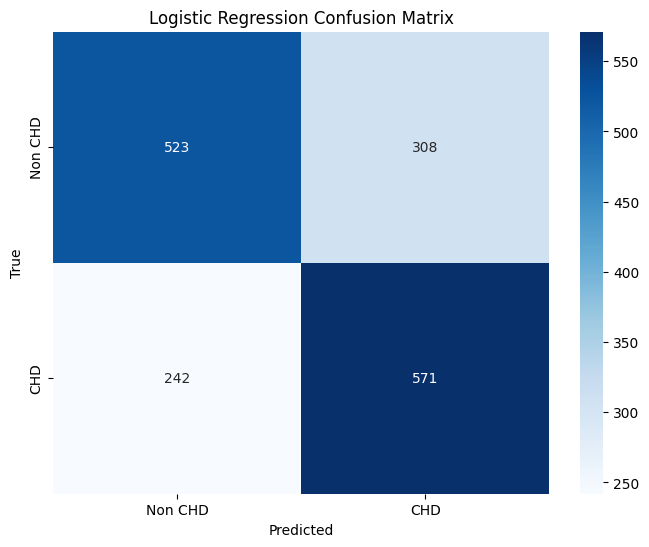

In [21]:
# Définition d'une fonction pour afficher la matrice de confusion
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non CHD', 'CHD'], yticklabels=['Non CHD', 'CHD'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()
# Convertir les prédictions de Spark DataFrame en Pandas DataFrame
log_reg_cm = best_log_reg_model.transform(testData).select("prediction", "ten_year_chd").toPandas()
# Calculer la matrice de confusion pour chaque modèle
log_reg_cm = confusion_matrix(log_reg_cm["ten_year_chd"], log_reg_cm["prediction"])
# Afficher les matrices de confusion
plot_confusion_matrix(log_reg_cm, 'Logistic Regression Confusion Matrix')

La matrice de confusion que nous avons affichée met en évidence la performance du modèle de régression logistique dans la prédiction des cas positifs et négatifs de développement de maladie cardiaque sur l'ensemble de test. Cependant, il est important de noter que le taux de faux négatifs est élevé, ce qui signifie que le modèle a du mal à détecter correctement les cas réels de développement de maladie cardiaque parmi ceux qui sont prédits comme non affectés.
Cette situation est particulièrement préoccupante dans le contexte médical, car un taux élevé de faux négatifs peut signifier que des individus à risque de développer une maladie cardiaque pourraient ne pas être identifiés

## **3. Decision Tree** 

Pour l'entraînement du modèle d'arbre de décision, nous avons suivi un processus similaire à celui de la régression logistique.

In [22]:
dt = DecisionTreeClassifier(labelCol="ten_year_chd", featuresCol="features")

In [23]:
param_grid_dt = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [5, 10, 15]) \
    .addGrid(dt.maxBins, [16, 32, 64]) \
    .build()

In [24]:
cv_dt = CrossValidator(estimator=dt,
                       estimatorParamMaps=param_grid_dt,
                       evaluator=evaluator,
                       numFolds=5)

In [25]:
cv_dt_model = cv_dt.fit(trainingData)

In [26]:
best_dt_model = cv_dt_model.bestModel

In [27]:
dt_test_results = evaluator.evaluate(best_dt_model.transform(testData))
print("Decision Tree Test Area Under ROC:", dt_test_results)

Decision Tree Test Area Under ROC: 0.8124963921119357


Les performances du meilleur modèle d'arbre de décision ont été évaluées sur l'ensemble de test, et l'aire sous la courbe ROC (ROC AUC) obtenue est d'environ 0.812.

In [28]:
# Afficher les meilleurs paramètres pour Decision Tree
best_dt_params = cv_dt_model.bestModel.extractParamMap()
print("Meilleurs paramètres pour Decision Tree:")
for param in best_dt_params:
    print(param.name, ":", best_dt_params[param])

Meilleurs paramètres pour Decision Tree:
cacheNodeIds : False
checkpointInterval : 10
featuresCol : features
impurity : gini
labelCol : ten_year_chd
leafCol : 
maxBins : 16
maxDepth : 15
maxMemoryInMB : 256
minInfoGain : 0.0
minInstancesPerNode : 1
minWeightFractionPerNode : 0.0
predictionCol : prediction
probabilityCol : probability
rawPredictionCol : rawPrediction
seed : -5274216314403460591


In [29]:
dt_predictions_pd = best_dt_model.transform(testData).select("prediction", "ten_year_chd").toPandas()
dt_metrics = classification_report(dt_predictions_pd["ten_year_chd"], dt_predictions_pd["prediction"], zero_division=0)
print("Decision Tree Classification Report:")
print(dt_metrics)

Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.72      0.76       831
           1       0.74      0.83      0.78       813

    accuracy                           0.77      1644
   macro avg       0.77      0.77      0.77      1644
weighted avg       0.77      0.77      0.77      1644



Globalement, le modèle d'arbre de décision semble plus performant par rapport au model de la regression logistic, avec des scores de précision, de rappel et de F1-score assez équilibrés pour les deux classes

In [30]:
# Calculer le recall pour l'ensemble de test
dt_test_recall = evaluator_recall.evaluate(best_dt_model.transform(testData))

# Calculer le recall pour l'ensemble d'entraînement
dt_train_recall = evaluator_recall.evaluate(best_dt_model.transform(trainingData))

print("Logistic Regression Test Recall:", dt_test_recall)
print("Logistic Regression Train Recall:", dt_train_recall)

Logistic Regression Test Recall: 0.7706812652068127
Logistic Regression Train Recall: 0.9795819154107924


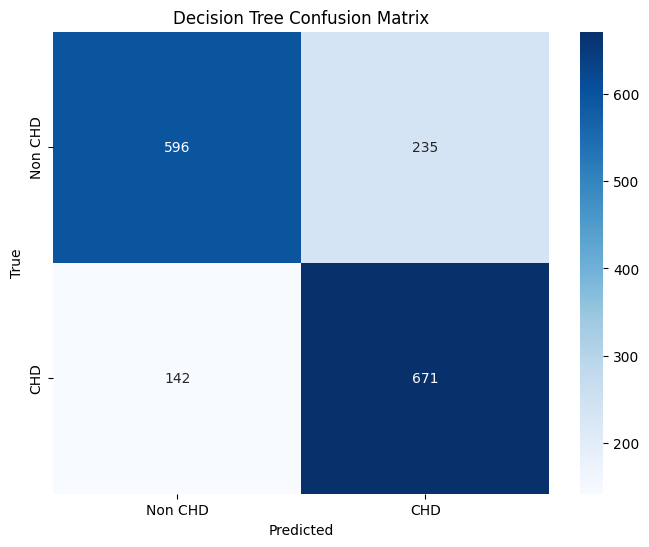

In [31]:
dt_cm = best_dt_model.transform(testData).select("prediction", "ten_year_chd").toPandas()
dt_cm = confusion_matrix(dt_cm["ten_year_chd"], dt_cm["prediction"])
plot_confusion_matrix(dt_cm, 'Decision Tree Confusion Matrix')

*avec l'arbre de décision, nous avons réussi à réduire le nombre de faux négatifs par rapport à la régression logistique. Cela indique que le modèle d'arbre de décision a une capacité modérément élevée à discriminer entre les individus à risque de développer une maladie cardiaque et ceux qui ne le sont pas, avec une performance supérieure à celle obtenue avec le modèle de régression logistique précédent. Cette amélioration pourrait indiquer que la structure d'arbre de décision est mieux adaptée à la nature des données ou qu'elle capture mieux les relations complexes entre les caractéristiques et la variable cible.*

## **4. Random Forest**


Dans ce passage vers l'utilisation du modèle de forêt aléatoire, nous tirons parti de l'observation que la structure du modèle d'arbre de décision s'est avérée être la mieux adaptée à nos données et capable de capturer les relations complexes entre les différentes caractéristiques. Sachant que la forêt aléatoire est construite à partir de plusieurs arbres de décision, il est logique de s'attendre à des performances encore meilleures.

En combinant les prédictions de multiples arbres de décision, la forêt aléatoire peut atténuer les biais individuels de chaque arbre et réduire le risque de sur-apprentissage aux données d'entraînement. En conséquence, nous anticipons des scores de performance plus élevés, reflétant une meilleure capacité à généraliser les relations entre les caractéristiques et la variable cible sur de nouvelles données.

In [32]:
rf = RandomForestClassifier(labelCol="ten_year_chd", featuresCol="features")

In [33]:
param_grid_rf = ParamGridBuilder() \
    .addGrid(rf.maxDepth, [5, 10, 15]) \
    .addGrid(rf.numTrees, [20, 50, 100]) \
    .build()

In [34]:
cv_rf = CrossValidator(estimator=rf,
                       estimatorParamMaps=param_grid_rf,
                       evaluator=evaluator,
                       numFolds=5)

In [35]:
cv_rf_model = cv_rf.fit(trainingData)

In [36]:
best_rf_model = cv_rf_model.bestModel

In [37]:
rf_test_results = evaluator.evaluate(best_rf_model.transform(testData))
print("Random Forest Test Area Under ROC:", rf_test_results)

Random Forest Test Area Under ROC: 0.9310082992526778


Le score d'aire sous la courbe ROC (ROC AUC) obtenu pour le modèle de forêt aléatoire est remarquablement élevé, atteignant environ 0.934. Cela indique une excellente capacité du modèle à discriminer entre les individus à risque de développer une maladie cardiaque et ceux qui ne le sont pas.

In [38]:
# Afficher les meilleurs paramètres pour Random Forest
best_rf_params = cv_rf_model.bestModel.extractParamMap()
print("Meilleurs paramètres pour Random Forest:")
for param in best_rf_params:
    print(param.name, ":", best_rf_params[param])

Meilleurs paramètres pour Random Forest:
bootstrap : True
cacheNodeIds : False
checkpointInterval : 10
featureSubsetStrategy : auto
featuresCol : features
impurity : gini
labelCol : ten_year_chd
leafCol : 
maxBins : 32
maxDepth : 15
maxMemoryInMB : 256
minInfoGain : 0.0
minInstancesPerNode : 1
minWeightFractionPerNode : 0.0
numTrees : 100
predictionCol : prediction
probabilityCol : probability
rawPredictionCol : rawPrediction
seed : -7033929482271434104
subsamplingRate : 1.0


In [39]:
rf_predictions_pd = best_rf_model.transform(testData).select("prediction", "ten_year_chd").toPandas()
rf_metrics = classification_report(rf_predictions_pd["ten_year_chd"], rf_predictions_pd["prediction"], zero_division=0)
print("Random Forest Classification Report:")
print(rf_metrics)

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.81      0.85       831
           1       0.82      0.89      0.85       813

    accuracy                           0.85      1644
   macro avg       0.85      0.85      0.85      1644
weighted avg       0.85      0.85      0.85      1644



In [40]:
# Calculer le recall pour l'ensemble de test
rf_test_recall = evaluator_recall.evaluate(best_rf_model.transform(testData))

# Calculer le recall pour l'ensemble d'entraînement
rf_train_recall = evaluator_recall.evaluate(best_rf_model.transform(trainingData))

print("Logistic Regression Test Recall:",rf_test_recall)
print("Logistic Regression Train Recall:", rf_train_recall)

Logistic Regression Test Recall: 0.8497566909975669
Logistic Regression Train Recall: 0.9934370442391833


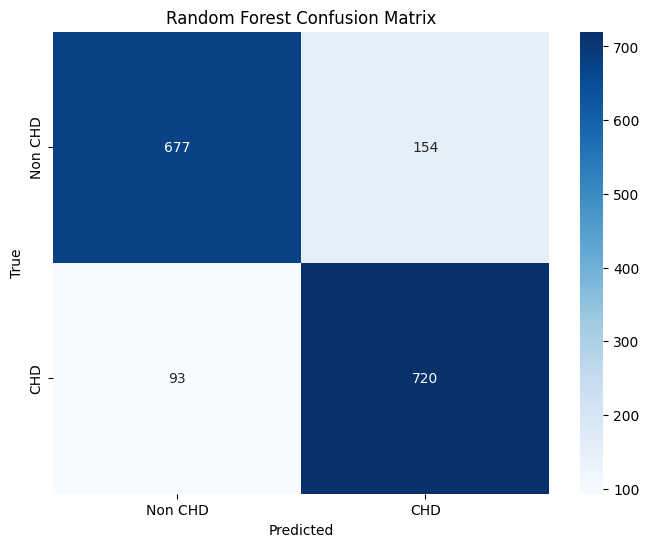

In [41]:
rf_cm = best_rf_model.transform(testData).select("prediction", "ten_year_chd").toPandas()
rf_cm = confusion_matrix(rf_cm["ten_year_chd"], rf_cm["prediction"])
plot_confusion_matrix(rf_cm, 'Random Forest Confusion Matrix')

En examinant la matrice de confusion, nous observons une nette amélioration par rapport aux modèles précédents, en particulier en ce qui concerne le taux de faux négatifs (FN). Cela confirme notre hypothèse initiale selon laquelle la forêt aléatoire a la capacité de mieux séparer les deux classes par rapport aux modèles individuels tels que la régression logistique et l'arbre de décision.

## **5. Support Vector Machine**

Dans notre démarche pour choisir le modèle le plus adapté, nous avons décidé de tester le modèle de Support Vector Machine (SVM) en raison de sa structure différente par rapport aux arbres de décision.

In [42]:
svm = LinearSVC(labelCol="ten_year_chd", featuresCol="features")

In [43]:
# Construire une grille de recherche de paramètres pour chaque modèle
paramGridSVM = ParamGridBuilder() \
    .addGrid(svm.maxIter, [10, 20, 30]) \
    .addGrid(svm.regParam, [0.1, 0.01]) \
    .build()

In [44]:
# Initialiser les validateurs pour SVM
cvSVM = CrossValidator(estimator=svm,
                       estimatorParamMaps=paramGridSVM,
                       evaluator=evaluator,
                       numFolds=5)

In [45]:
# Entraîner les validateurs
cvSVM_model = cvSVM.fit(trainingData)


In [46]:
# Sélectionner les meilleurs modèles
best_svm_model = cvSVM_model.bestModel

In [47]:
svm_test_results = evaluator.evaluate(best_svm_model.transform(testData))
print("Support Vector Machine Test Area Under ROC:", svm_test_results)

Support Vector Machine Test Area Under ROC: 0.7322776837876702


Le score d'aire sous la courbe ROC (ROC AUC) obtenu pour le modèle de Support Vector Machine (SVM) est d'environ 0.732

In [48]:
# Afficher les meilleurs paramètres pour SVM.
print("Meilleurs paramètres pour SVM:")
print("MaxIter:", best_svm_model.getMaxIter())
print("RegParam:", best_svm_model.getRegParam())

Meilleurs paramètres pour SVM:
MaxIter: 30
RegParam: 0.01


In [49]:
# Convertir les prédictions de Spark DataFrame en Pandas DataFrame
svm_predictions_pd = best_svm_model.transform(testData).select("prediction", "ten_year_chd").toPandas()
# Utiliser classification_report de scikit-learn sur les données Pandas avec zero_division=0
svm_metrics = classification_report(svm_predictions_pd["ten_year_chd"], svm_predictions_pd["prediction"], zero_division=0)
print("support vector machine Classification Report:")
print(svm_metrics)

support vector machine Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.61      0.65       831
           1       0.64      0.72      0.68       813

    accuracy                           0.67      1644
   macro avg       0.67      0.67      0.66      1644
weighted avg       0.67      0.67      0.66      1644



In [50]:
# Calculer le recall pour l'ensemble de test
svm_test_recall = evaluator_recall.evaluate(best_svm_model.transform(testData))

# Calculer le recall pour l'ensemble d'entraînement
svm_train_recall = evaluator_recall.evaluate(best_svm_model.transform(trainingData))

print("Logistic Regression Test Recall:", svm_test_recall)
print("Logistic Regression Train Recall:", svm_train_recall)

Logistic Regression Test Recall: 0.6654501216545012
Logistic Regression Train Recall: 0.6745260087506076


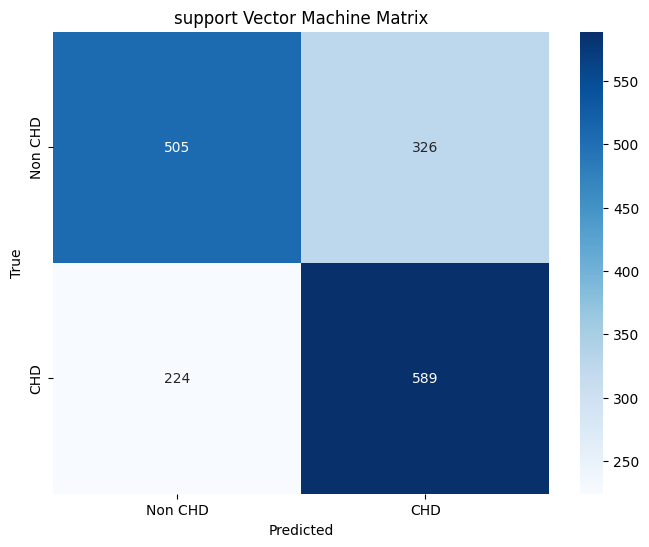

In [51]:
svm_cm = best_svm_model.transform(testData).select("prediction", "ten_year_chd").toPandas()
svm_cm = confusion_matrix(svm_cm["ten_year_chd"], svm_cm["prediction"])
plot_confusion_matrix(svm_cm, 'support Vector Machine Matrix')

Nous avons obtenu un taux de faux négatifs élevé par rapport au modèle de forets aléatoires, ce qui souligne une limitation significative du modèle de Support Vector Machine (SVM) dans la détection des cas réels de développement de maladie cardiaque parmi ceux qui sont prédits comme n'en ayant pas.

## **6. Resultats**

In [119]:
# Summarizing the results obtained
test = PrettyTable(['Sl. No.','Classification Model', 'Train Recall (%)','Test Recall (%)'])
test.add_row(['1','Logistic Regression',log_reg_train_recall*100,log_reg_test_recall*100])
test.add_row(['2','Decision Tree',dt_train_recall*100,dt_test_recall*100])
test.add_row(['3','Support Vector Machines',svm_train_recall*100,svm_test_recall*100])
test.add_row(['4','Random Forests',rf_train_recall*100,rf_test_recall*100])
print(test)

+---------+-------------------------+-------------------+-------------------+
| Sl. No. |   Classification Model  |  Train Recall (%) |  Test Recall (%)  |
+---------+-------------------------+-------------------+-------------------+
|    1    |   Logistic Regression   |  67.0393777345649 | 66.54501216545012 |
|    2    |      Decision Tree      | 97.95819154107924 | 77.06812652068126 |
|    3    | Support Vector Machines | 67.45260087506077 | 66.54501216545012 |
|    4    |      Random Forests     | 99.39231891103549 | 84.36739659367396 |
+---------+-------------------------+-------------------+-------------------+


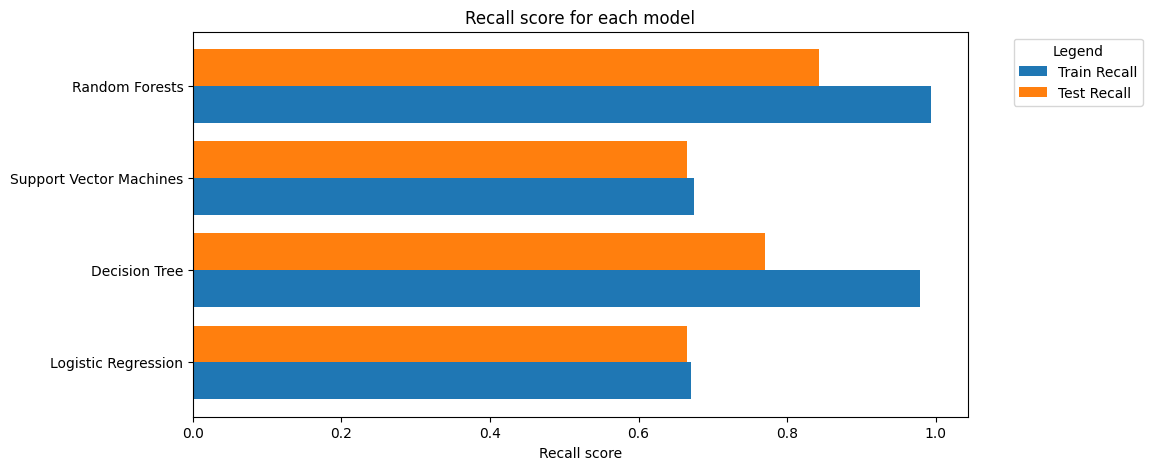

In [67]:
# Plotting Recall scores

ML_models = ['Logistic Regression','Decision Tree','Support Vector Machines','Random Forests']
train_recalls = [log_reg_train_recall,dt_train_recall,svm_train_recall,rf_train_recall]
test_recalls = [log_reg_test_recall,dt_test_recall,svm_test_recall,rf_test_recall]
  
X_axis = np.arange(len(ML_models))

plt.figure(figsize=(10,5))
plt.barh(X_axis - 0.2, train_recalls, 0.4, label = 'Train Recall')
plt.barh(X_axis + 0.2, test_recalls, 0.4, label = 'Test Recall')
  
plt.yticks(X_axis,ML_models)
plt.xlabel("Recall score")
plt.title("Recall score for each model")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left',title='Legend')
plt.show()

En conclusion, notre étude comparative des différents modèles pour la prédiction des maladies cardiaques a révélé des performances variables. Tout d'abord, nous avons constaté que les modèles d'arbre de décision et de forêt aléatoire ont montré des performances globalement meilleures que la régression logistique et le modèle de Support Vector Machine (SVM). En particulier, la forêt aléatoire a présenté les performances les plus élevées, avec une ROC AUC d'environ 0.934, ce qui indique une capacité exceptionnelle à discriminer entre les individus à risque de développer une maladie cardiaque et ceux qui ne le sont pas, tout en réduisant le taux de faux négatifs.

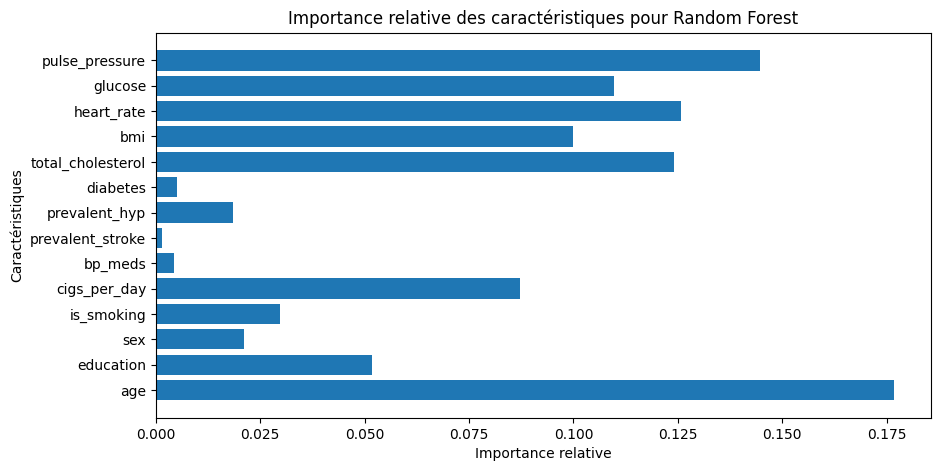

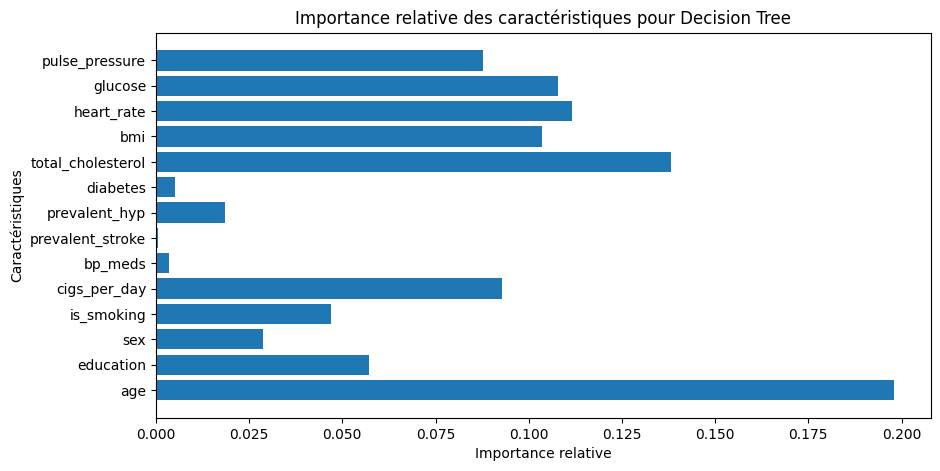

In [70]:
import matplotlib.pyplot as plt

# Random Forest
rf_feature_importance = best_rf_model.featureImportances
plt.figure(figsize=(10, 5))
plt.barh(feature_columns, rf_feature_importance.toArray())
plt.xlabel('Importance relative')
plt.ylabel('Caractéristiques')
plt.title('Importance relative des caractéristiques pour Random Forest')
plt.show()

# Decision Tree
dt_feature_importance = best_dt_model.featureImportances
plt.figure(figsize=(10, 5))
plt.barh(feature_columns, dt_feature_importance.toArray())
plt.xlabel('Importance relative')
plt.ylabel('Caractéristiques')
plt.title('Importance relative des caractéristiques pour Decision Tree')
plt.show()

En analysant l'importance des caractéristiques dans les deux meilleurs modèles, nous constatons que l'âge est identifié comme la caractéristique la plus importante. Cette observation suggère que l'âge peut jouer un rôle significatif dans le risque de développer des maladies coronariennes.

## **7. Meuilleur modèle (Random Forest)**

In [54]:
# Convertir les prédictions Spark DataFrame en Pandas DataFrame
rf_predictions_pd = best_rf_model.transform(testData).select("age", "education", "sex", "is_smoking", "cigs_per_day", "bp_meds", "prevalent_stroke", "prevalent_hyp", "diabetes", "total_cholesterol", "bmi", "heart_rate", "glucose", "pulse_pressure", "ten_year_chd","prediction").toPandas()
# Enregistrer les prédictions dans des fichiers CSV
rf_predictions_pd.to_csv('random_forest_predictions.csv', index=False)

In [55]:
rf_predictions_pd.head(20)

,age,education,sex,is_smoking,cigs_per_day,bp_meds,prevalent_stroke,prevalent_hyp,diabetes,total_cholesterol,bmi,heart_rate,glucose,pulse_pressure,ten_year_chd,prediction
0,33,2,1,0,0,0,0,1,0,165.000000,26.740000,54.000000,77.000000,46.500000,0,0.0
1,34,1,0,1,10,0,0,0,0,185.000000,19.680000,75.000000,79.700000,22.500000,0,0.0
2,34,1,1,1,5,0,0,0,0,185.000000,24.420000,70.000000,115.000000,34.500000,0,0.0
3,34,1,1,1,10,0,0,0,0,210.000000,24.390000,68.000000,70.700000,35.000000,0,0.0
4,34,2,0,1,20,0,0,0,0,180.000000,21.510000,91.000000,78.000000,55.000000,0,0.0
5,34,2,0,1,20,0,0,0,0,220.000000,20.790000,63.000000,86.000000,50.000000,0,0.0
6,34,2,1,1,25,0,0,0,0,250.000000,29.040000,63.000000,80.000000,42.000000,0,0.0
7,34,3,1,1,20,0,0,0,0,155.000000,23.510000,85.000000,65.000000,45.000000,0,0.0
8,35,1,0,0,0,0,0,0,0,170.000000,23.480000,75.000000,83.000000,41.000000,0,0.0
9,35,1,1,0,0,0,0,0,0,275.000000,34.040000,75.000000,80.000000,53.500000,0,0.0
